# BootstrapEstimator: bootstrap estimates for machine learning

The basic idea behind the [bootstrap method](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is to generate a large number of bootstrap replicas from a dataset and calculate the model performance for each separately. This allows the calculation of statistical metrics for the model such as a confidence interval for the accuracy.

Although a relatively simple task, this class makes this process automatic, inclding generating a plot. The use and conventions are aimed to follow those in [sklearn](https://scikit-learn.org/stable/) as closely as possible. 

In this notebook we show the usage with the help of data from [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/data?select=test.csv).

In [1]:
import pandas as pd

df = pd.read_csv('data/data.csv')
df.head(5)

,Pclass,Age,Fare,Soc_class,FamSize,Survived_yes,Sex_male,Cabin_yes,Embarked_Q,Embarked_S
0,3,22.0,7.2500,0,1,0,1,0,0,1
1,1,38.0,71.2833,0,1,1,0,1,0,0
2,3,26.0,7.9250,0,0,1,0,0,0,1
3,1,35.0,53.1000,0,1,1,0,1,0,1
4,3,35.0,8.0500,0,0,0,1,0,0,1


## 1 Minimal working example
As a bare bones example we show how to generate bootsrapped statistics for the accuracy (*sklearn.metrics.accuracy_score*) of a DecisionTreeClassifer trained to predict the <font color='red'>'Survived_yes'</font> column of the data. Note that we have simply chosen *accuracy_score*, but all other metrics available from from *sklearn.metrics* (as well as one's own) are equally valid.

In [2]:
from BootstrapEstimator import BootstrapEstimator
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score

# Data
X, y = df.drop(['Survived_yes'], axis = 1), df['Survived_yes']

# Create an instance of the class
BE_tree = BootstrapEstimator(DTC(max_depth = 5))

# Generate bootstrapped datasets, fit and calculate the accuracy for a test/training split for each replica
BE_tree.fit_calculate(X, y, accuracy_score)

###  The results for the training set, the test set as well as the classifier are available as attributes:
 Specifically, **.results[**<font color='red'>'train'</font>**]** and **.results[**<font color='red'>'test'</font>**]** given as numpy arrays and the classifier is accessible as **.classifier**.

In [3]:
import numpy as np

# Calculate some relvant statistics with numpy
for key in {'train', 'test'}:
    print('mean({}): {:.4}'.format(key, np.mean(BE_tree.results[key])))
    print('std({}): {:.4}'.format(key, np.std(BE_tree.results[key])))

mean(test): 0.8314
std(test): 0.02595
mean(train): 0.8714
std(train): 0.01488


In [4]:
# The classifier has the usual sklearn methods
print('Model parameters: {}'.format(BE_tree.classifier.get_params()))

Model parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


### Histogram for the accuracies of test and training set available as a method

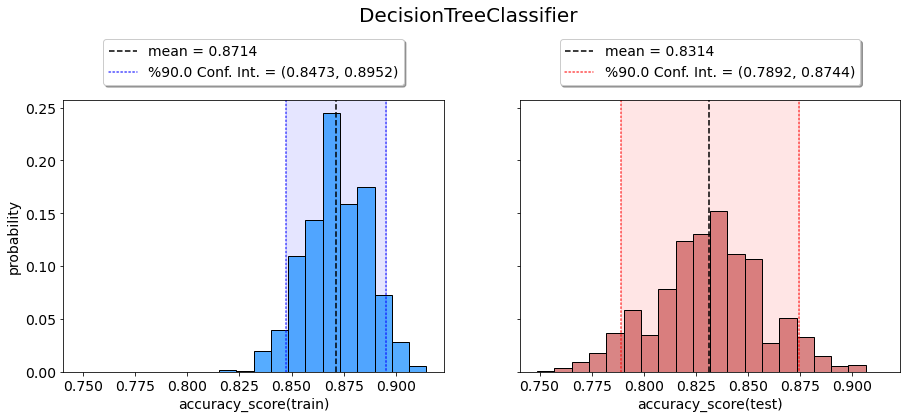

In [5]:
BE_tree.plot()

## 2 Example with all available functionality

Here we will train a linear regressor to predict the <font color='red'>'Age'</font> while setting all the available variables for **.fit_calculate** and **.plot()** explicitly.

The available parameters are:
- **scaler: function, default = None**. Allows preprocessing of training data.
- **n: int, default = 1000.** The number of bootsrapped replicas that are generated.
- **frac: float, default = 1.0.** The size (length with respect to initial data) of a bootstrapped replica dataset. Gets passed to *pandas.DataFrame.sample*.
- **test_size: float or int, default = 0.25.** Gets passed into *sklearn.model_selection.train_test_split*.
- **random_state: int, default = None.** Pass an int for reproducability (like in *sklearn*).
- **stratify: array-like, default = None.** Gets passed into *sklearn.model_selection.train_test_split*.
- **verbose: bool, default = False.** Prints the percentage done and the time remaining. Useful for larger datasets and models that take a while to train.

In [6]:
from BootstrapEstimator import BootstrapEstimator
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Data
X, y = df.drop(['Age'], axis = 1), df['Age']

# Create an instance of the class
BE_linear = BootstrapEstimator(LR())

# Create an instance of MinMaxScaler (although for this example not really needed)
sclr = MinMaxScaler()

# Using a self-defined function for the accuracy
def root_mean_squared_error(x,y):
    return mean_squared_error(x,y)**(1/2)

# Fit and calculate the RMS, with parameters as explained above
BE_linear.fit_calculate(X, y, root_mean_squared_error, scaler = sclr, n = 10000, frac = 0.9,
                        test_size = 0.1, random_state = 1, stratify = None, verbose = True)

done                                                                                                    


### Available histogram parameters

- **bins: int, default = 20.** The maximum number of bins in a panel. Since binwidth is fixed, the panels don't have equal bin numbers.
- **conf: float, default = 0.9.** The confidence interval centered around the mean.
- **stat: {'count', 'frequency', 'density', 'probability'}, default = 'probability'.** Gets passed in into *seaborn.histplot*.

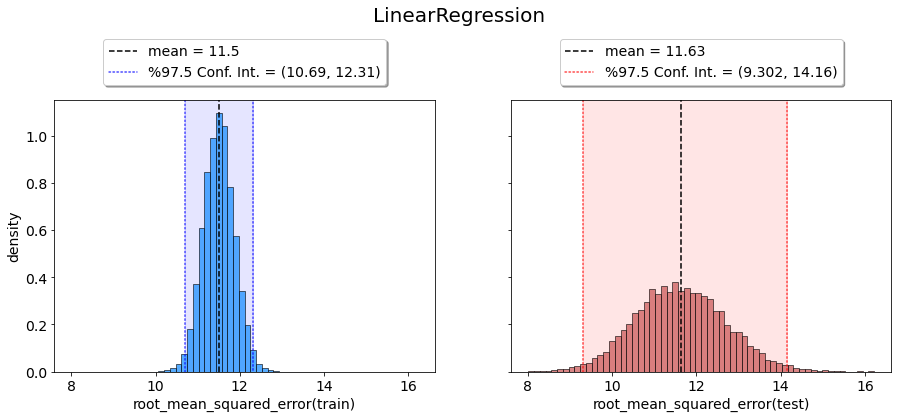

In [7]:
BE_linear.plot(bins = 60, conf = 0.975, stat = 'density')

#### Local library versions

In [8]:
import sklearn as sk
import seaborn as sns
import matplotlib as mp
print(pd.__version__, np.__version__, sk.__version__, mp.__version__, sns.__version__)

1.1.3 1.19.2 0.23.2 3.3.2 0.11.0
